Importing necessary libraries

In [3]:
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

Loading and visualizing time series data

In [4]:
# Import data
df = pd.read_csv('website_data.csv', names=['value'], header=0)
df

,value
0,932
1,929
2,938
3,964
4,990
...,...
388,4667
389,4701
390,4721
391,4757


<Axes: >

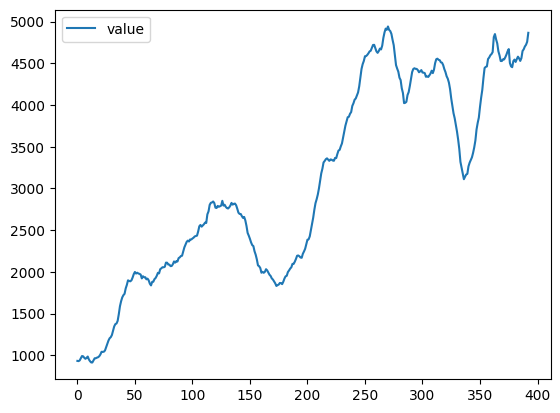

In [ ]:
df.plot()

<Axes: >

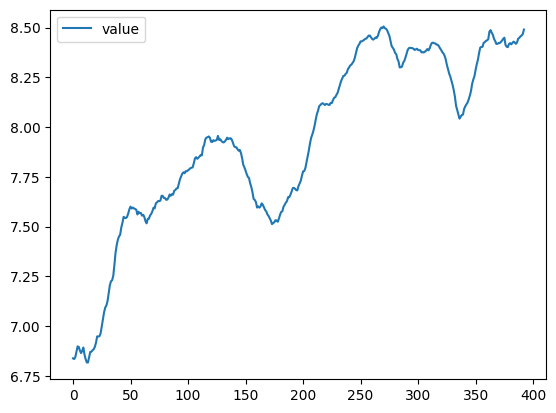

In [6]:
df = np.log(df)
df.plot()

# untuk menghitung tingkat pertumbuhan, Mengelola dan mengubah data untuk mencapai kenormalan dalam model statistik

In [7]:
mask = (df.index < len(df) - 30)

df_train = df[mask].copy()
df_test = df[~mask].copy()

print('data train :', df_train.shape, 'data test:', df_test.shape)

data train : (363, 1) data test: (30, 1)


Check Stationary

#1 Time Series Plot

#2 ACF and PACF plot

[]

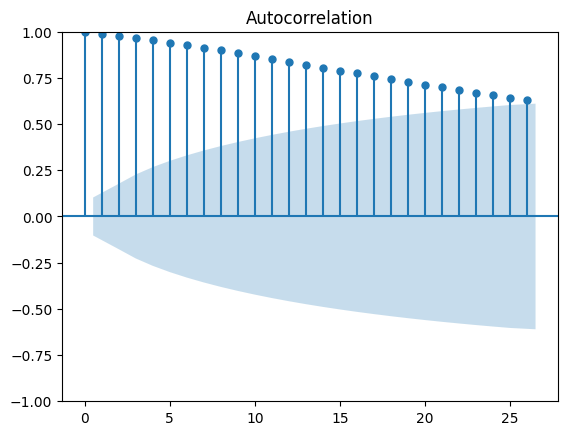

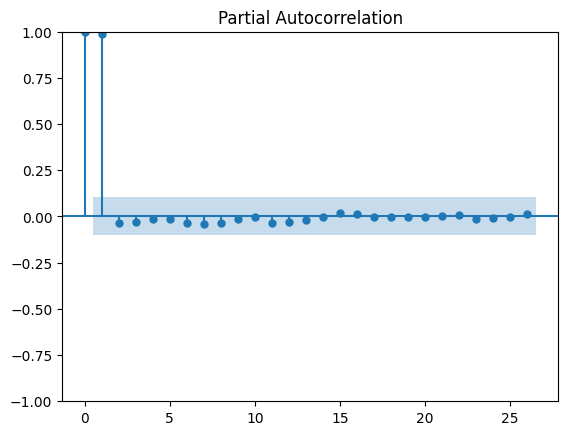

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_train)
plot_pacf(df_train)

plt.plot()

#3 ADF Test

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_train)
print('ADF Statistic: %f' % result[0])
print('P-value: %f' % result[1])

# Since P-value is greater than the ( 0.05 ) significance level, let’s difference the series and see how the autocorrelation plot looks like.

ADF Statistic: -2.108122
P-value: 0.241261


Transform to Stationary ( Differencing )

<Axes: >

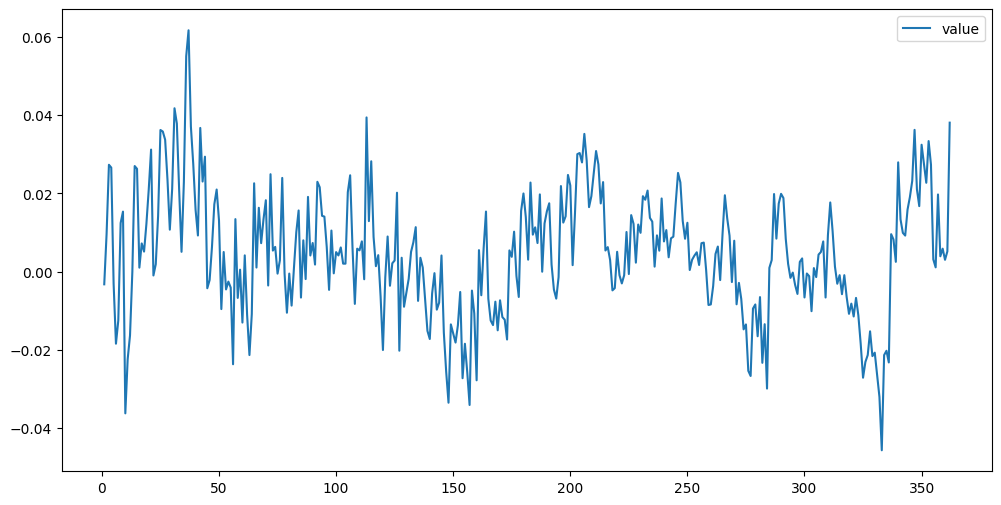

In [11]:
df_train_diff = df_train.diff().dropna()

df_train_diff.plot(figsize=(12, 6))

[]

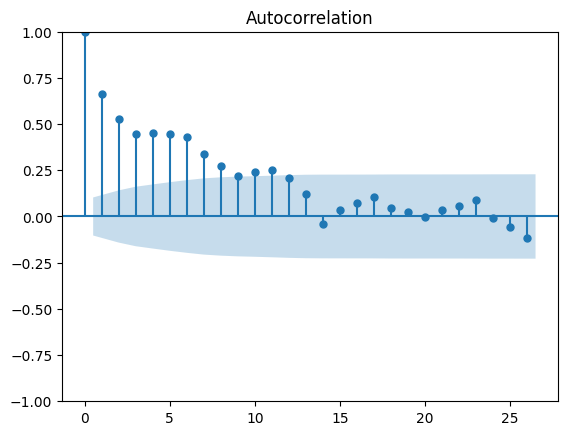

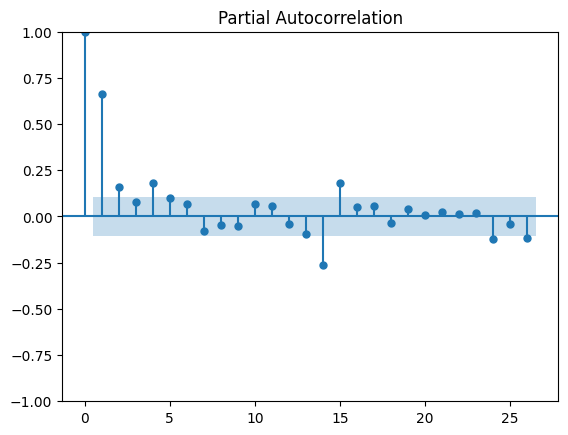

In [12]:
plot_acf(df_train_diff)
plot_pacf(df_train_diff)

plt.plot()

In [13]:
# ADF Test after differencing

result = adfuller(df_train_diff)
print('ADF Statistic: %f' % result[0])
print('P-value: %f' % result[1])

# the P-value after differencing is less than 0.05, so the data is stationary.
# if the P-value still show non-stationary / bigger than significance level, we can differencing again.

ADF Statistic: -3.165676
P-value: 0.022059


Determine ARIMA Models

In [14]:
# If the PACF plot has a significant spike at lag p, but not beyond; the ACF plot decays more gradually. This may suggest an ARIMA(p, d, 0) model.

# If the ACF plot has a significant spike at lag q, but not beyond; the PACF plot decays more gradually. This may suggest an ARIMA(O, d, q) model.

Fit ARIMA Models

In [15]:
import statsmodels.api as sm

# 1,1,2 ARIMA Model
model = sm.tsa.arima.ARIMA(df_train, order=(2, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  363
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1096.369
Date:                Sat, 22 Feb 2025   AIC                          -2186.737
Time:                        16:47:35   BIC                          -2175.063
Sample:                             0   HQIC                         -2182.096
                                - 363                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5806      0.050     11.662      0.000       0.483       0.678
ar.L2          0.1687      0.058      2.903      0.004       0.055       0.283
sigma2         0.0001   8.23e-06     16.612      0.0

Make Time Series Predictions

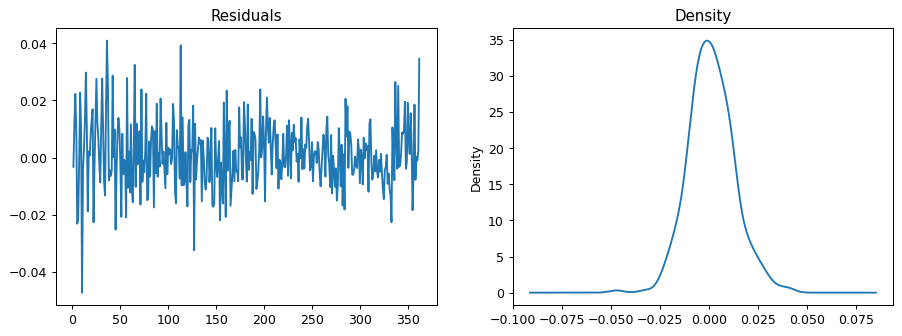

In [16]:
plt.rcParams.update({'figure.figsize': (12, 4), 'figure.dpi': 90})

residuals = model_fit.resid[1:]

fig, ax = plt.subplots(1, 2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

[]

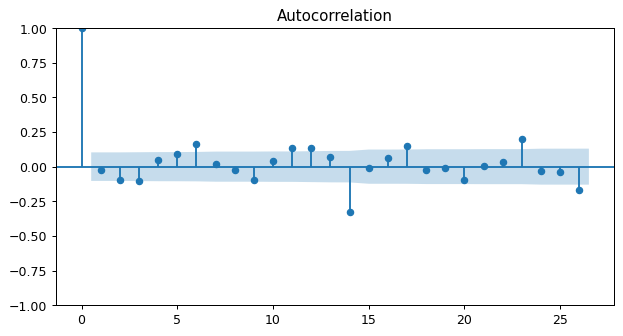

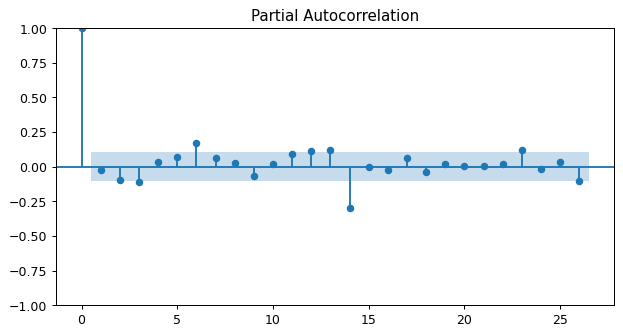

In [17]:
plt.rcParams.update({'figure.figsize': (8, 4), 'figure.dpi': 90})

plot_acf(residuals)
plot_pacf(residuals)

plt.plot()

<Axes: >

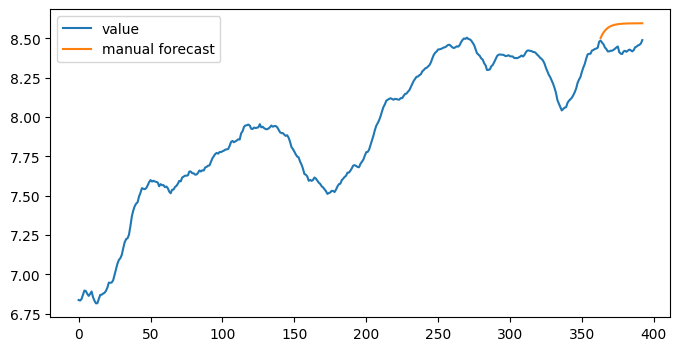

In [18]:
plt.rcParams.update({'figure.figsize': (8, 4), 'figure.dpi': 100})

forecast = model_fit.forecast(len(df_test))

df['manual forecast'] = [None] * len(df_train) + list(forecast)

df.plot()

Using Auto ARIMA model

In [ ]:
import pmdarima as pm

auto_arima = pm.auto_arima(df_train, trace=True, surpress_warnings=True, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(5, 1, 0), scoring_args={}, suppress_warnings=True)

In [20]:
print(auto_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  363
Model:               SARIMAX(5, 1, 0)   Log Likelihood                1107.359
Date:                Sat, 22 Feb 2025   AIC                          -2200.719
Time:                        16:47:45   BIC                          -2173.477
Sample:                             0   HQIC                         -2189.889
                                - 363                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.001      1.511      0.131      -0.000       0.002
ar.L1          0.5213      0.052      9.979      0.000       0.419       0.624
ar.L2          0.0934      0.065      1.434      0.1

Evaluate Model Prediction

<Axes: >

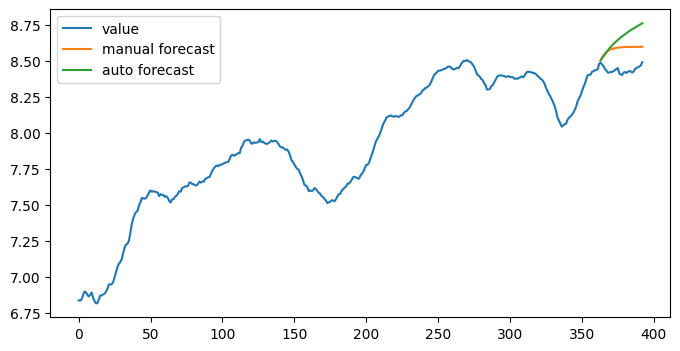

In [21]:
forecast_test_auto = auto_arima.predict(n_periods=len(df_test))
df['auto forecast'] = [None] * len(df_train) + list(forecast_test_auto)

df.plot()

In [27]:
from sklearn.metrics import  mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

mae = mean_absolute_error(df_test, forecast)
mse = mean_squared_error(df_test, forecast)
mape = mean_absolute_percentage_error(df_test, forecast)

print('MAE: ', mae)
print('MSE: ', mse)
print('MAPE: ', mape)

MAE:  0.14514968388076604
MSE:  0.022654475933402526
MAPE:  0.017216198515850756


In [30]:
mae_auto = mean_absolute_error(df_test, forecast_test_auto)
mse_auto = mean_squared_error(df_test, forecast_test_auto)
mape_auto = mean_absolute_percentage_error(df_test, forecast_test_auto)

print('MAE auto: ', mae_auto)
print('MSE auto: ', mse_auto)
print('MAPE auto: ', mape_auto)

MAE auto:  0.2170189529162375
MSE auto:  0.05350613613295096
MAPE auto:  0.025733565677742667
